# **HOUSING PRICE**



# **Parte A - Transformación de Datos**


Las distintas tareas de transformación se realizarán de manera intercalada, a continuación se comentará brevemento lo realizado.

- Consistencia: permite filtrar aquellas instancias que no cumplan con "reglas de negocio" como superficie cubierta menor a superficie total, cantidad de baños mayor a cantidad de ambientes, etc. Es muy importante realizar este tipo de filtros dado que errores al ingresar los datos pueden generar grandes distorciones.

- Detección y eliminación de Outliers: Los valores atípicos se eliminarán analizando la relación con otras features relevantes. Un ejemplo que sirve como sustento metodológico: Es adecuado eliminar una propiedad con muchas habitaciones por presentar un valor por fuera del iqr global? No sería mejor hacerlo considerando un iqr de acuerdo al tipo de propiedad? Podríamos pensar, a priori, que las casas tienen una mayor cantidad de habitaciones que los departamentos. Otra razón que justifica esta forma de proceder es evitar un empobrecimiento del tipo de propiedad casa, que de por sí cuenta con una proporción más pequeña que departamentos.

- Encoding: se utilizará para las variables categóricas, siempre que no lleve a una creación excesiva de features se utilizará el "one hot encoding".

- Imputación de valores faltantes: nuevamente, es importante analizar la relación con otras variables. Un groupby antes de realizar la imputación es una metodología no del todo certera pero, sin dudas, es superior a la imputación de una media global. A su vez, evitaremos imputar las variables fundamentales ya que generaremos una distorción en las predicciones ("predecir sobre una predicción").

- Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA): se crearán varios nuevos features y luego se analizará su potencial predictorio, además, la creación de una variable surface_discovered (diferencia entre surface_total y surface_covered), nos sirve para quitar valores atipicos.

- Escalado de datos: dado que solo utilizaremos modelos basados en árboles, esta transformación no es necesaria.


In [1]:
#librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import csv
prop=pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

#Mask propiedades en Cf, tipo departamento, ph o casa.
prop=prop[(prop.l2=="Capital Federal")&
          ((prop.property_type=="Departamento")|(prop.property_type=="PH")|(prop.property_type=="Casa"))]

#Describe
prop.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,-34.593779,-58.441239,Argentina,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


Las columnas descripción, lat, lon, start_date, start_end y created on nos proveen información que excede los requerimientos de este trabajo, sin embargo, nos serán de utilidad para filtrar aquellas instancias repetidas. A su vez, se excluirá la variable bedrooms porque en las referencias de la página de Properati, se indica que no es relevante para las propiedades de Argentina.

In [3]:
#drop duplicates
prop=prop.drop_duplicates()

#reorganizacion de columnas
prop=prop[['rooms','bathrooms','surface_covered','surface_total','property_type','l3','price',]]

#head
prop.head()

,rooms,bathrooms,surface_covered,surface_total,property_type,l3,price
0,7.0,2.0,140.0,140.0,Departamento,San Cristobal,153000.0
1,2.0,2.0,58.0,70.0,PH,Boedo,159000.0
2,2.0,1.0,45.0,45.0,PH,Palermo,125000.0
3,2.0,1.0,50.0,85.0,PH,Palermo,295000.0
5,2.0,1.0,56.0,56.0,PH,Villa Crespo,150000.0


# Variables Categóricas ex-ante

Analizaremos rápidamente property type y l3, tanto antes como después del procesamiento del dataset para evitar la pérdida de labels o quita excesiva de datos en ellas (principalmente teniendo en cuenta que hay varias que cuentan con pocas instancias).

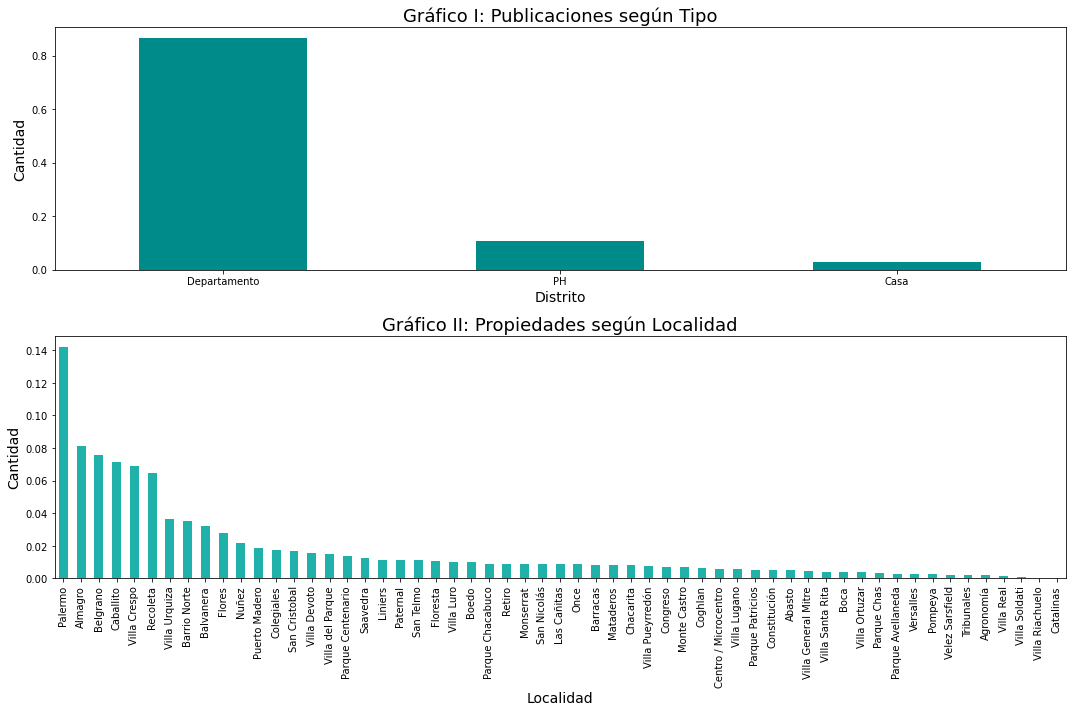

In [4]:
4. #Gráfico de barras de las publicaciones según región.
fig, axes = plt.subplots(figsize=(15,10),nrows=2, ncols=1)

sub1=prop['property_type'].value_counts(normalize=True).plot(ax=axes[0],kind='bar',color='darkcyan')
axes[0].set_title("Gráfico I: Publicaciones según Tipo",fontsize=18)
axes[0].set_ylabel('Cantidad',fontsize=14)
axes[0].set_xlabel('Distrito',fontsize=14)
plt.setp(sub1.xaxis.get_majorticklabels(), rotation=0)

sub2=prop['l3'].value_counts(normalize=True).plot(ax=axes[1],kind='bar',color='lightseagreen')
axes[1].set_title("Gráfico II: Propiedades según Localidad",fontsize=18)
axes[1].set_ylabel('Cantidad',fontsize=14)
axes[1].set_xlabel('Localidad',fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
prop.l3.nunique()

57

- **Gráfico I:** los departamentos son el tipo de propiedad más frecuente. 

- **Gráfico II:** de los 57 barrios, es más habitual encontrar publicaciones de aquellos más caros (el precio por metro cuadrado será analizado más adelante). 
Nuevamente, al quitar outliers es primordial aceptar un criterio que permita no afectar las clases con menos instancias, por lo que no se utilizará un método global y se diferenciará por tipo de propiedad o barrio según corresponda, para asegurarnos represntatividad tanto en "casas" como en los barrios menos publicados.



# Variables Cuantitativas

In [6]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_total,price
count,89874.000000,87727.000000,80850.000000,81157.000000,8.987400e+04
mean,2.965129,1.558562,95.169746,112.885494,2.587195e+05
std,1.317503,0.858386,785.177443,989.133753,3.190762e+05
min,1.000000,1.000000,1.000000,10.000000,6.000000e+03
25%,2.000000,1.000000,44.000000,49.000000,1.200000e+05
50%,3.000000,1.000000,63.000000,71.000000,1.750000e+05
75%,4.000000,2.000000,96.000000,111.000000,2.782000e+05
max,26.000000,14.000000,126062.000000,126062.000000,3.243423e+07


- Todos los features discretos presentan valores máximos que deben analizarse (rooms, bedrooms y bathrooms).

- En el caso de las continuas además deberán revisarse los valores mínimos (surface covered, surface total y price).

- El count indica la existencia de valores faltantes.

# Missing Values

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


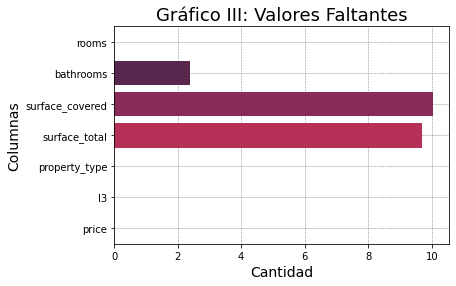

,Total,Percent
surface_covered,9024,10.04
surface_total,8717,9.70
bathrooms,2147,2.39


In [7]:
#Valores faltantes
missing=prop.isna().sum()/len(prop)*100
#se crea otra serie para usar como variable independiente.
columnas=prop.columns

##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico III: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()

def missing_percentage(df):
    total = prop.isnull().sum().sort_values(ascending = False)[prop.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(prop.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(prop.isnull().sum().sort_values(ascending = False)/len(prop)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(prop)

**Gráfico III:** la mayor cantidad de valores faltantes se dan en superficie cubierta.

- De acuerdo a lo analizado en el tp1, la superficie cubierta es el principal indicador para establecer el precio de una propiedad, por esta razon, no es recomendable imputar sus valores faltantes. Además, por tratarse de una variable continua, la calidad de las ppuede afectar la calidad de las predicciones.

- Para baños podríamos utilizar una imputación del tipo mediana (debemos imputar valores enteros, se verá más adelante).

# Correlaciones y lineamientos generales.

Text(0.5, 1.0, 'Gráfico IV: Heatmap')

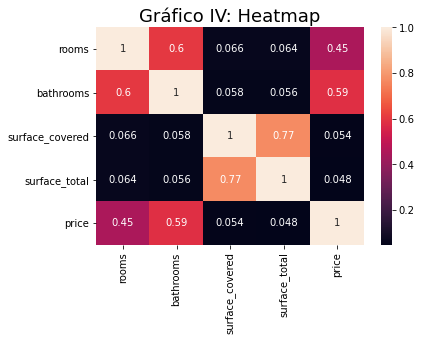

In [8]:
corr=prop.corr()
sns.heatmap(corr,annot=True)
plt.title("Gráfico IV: Heatmap",fontsize=18)

Las correlatividades están afectadas por la existencia de outliers.
Nuestra variable Objetivo es precios, por lo tanto será la última en ser analizada. Comenzaremos por aquellas que tienen menor correlatividad (de nuestra experiencia en el tp1, sabemos que la variable más importante es superficie cubierta), tratando de quitar tanto inconsistencias como outliers e iremos avanzando hacia los features más relevantes, en los que haremos un tratamiento más sutil.
Veremos que todas los features tienen una distribución aproximadamente normal con cola hacia la derecha, por lo que a la hora de quitar los outliers se considerarán tres desvíos hacia la derecha y dos hacia la izquierda.

# Análisis de Outliers en Rooms

Text(0.5, 0.98, 'Gráfico V: Distribución de rooms')

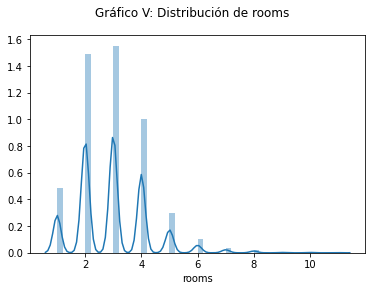

In [9]:
prop=prop[prop.rooms<12]
sns.distplot(prop.rooms)
plt.suptitle("Gráfico V: Distribución de rooms")

- **Gráfico V:** los ambientes tienen una distribución con cola hacia la derecha. La moda es una habitación y la media, dos.

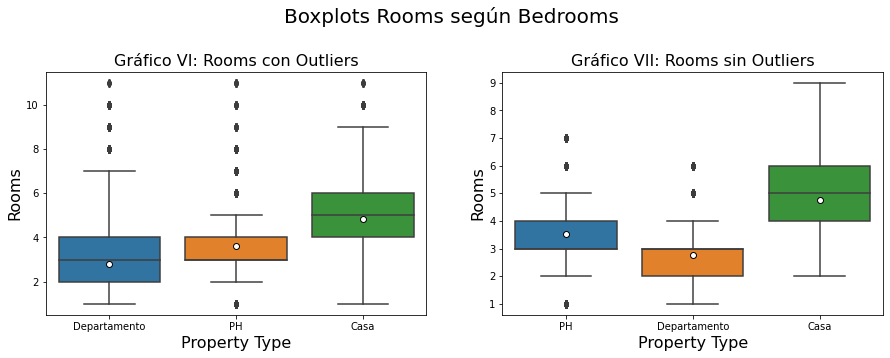

In [10]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Boxplots Rooms según Bedrooms',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = prop, x = "property_type",y='rooms',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

#filtro
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)
prop= prop[~prop.groupby('property_type')['rooms'].apply(is_outlier)]

sns.boxplot(data = prop, x = "property_type",y='rooms',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico VI: Rooms con Outliers",fontsize=16)
ax2.set_title("Gráfico VII: Rooms sin Outliers",fontsize=16)
ax1.set_xlabel('Property Type',fontsize=16)
ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Property Type',fontsize=16)
ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

**- Gráfico VI** Se observan inconsistencias entre el número de habitaciones y ambientes.

**- Gráfico VII** Se quitan las instancias mencionadas.

Nuevamente, se tiene especial atención para no borrar demasiados instancias para los valores más altos para no afectar la cantidad final de casas.

In [11]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_total,price
count,88955.000000,86812.000000,79953.000000,80260.000000,8.895500e+04
mean,2.909786,1.539983,93.006291,110.440257,2.519465e+05
std,1.184789,0.829890,789.179642,994.200280,3.031965e+05
min,1.000000,1.000000,1.000000,10.000000,6.000000e+03
25%,2.000000,1.000000,44.000000,49.000000,1.200000e+05
50%,3.000000,1.000000,62.000000,70.000000,1.750000e+05
75%,4.000000,2.000000,95.000000,109.000000,2.718400e+05
max,9.000000,14.000000,126062.000000,126062.000000,3.243423e+07


# - **IMPUTACIÓN DE BATHROOMS Y ELIMINACIÓN DE OUTLIERS**:

Hay más de 2000 instancias de baños a imputar, aprovecharemos la alta correlatividad con rooms para imputar su valor medio.
No utilizamos la media porque debemos imputar valores enteros.
A pesar de contar con mayor correlatividad, no utilizaremos la agrupación por bedrooms dado que bathrooms posee mayor subdivisiones (tiene un máximo de 9, contra 6 máximo en bedrooms)

In [12]:
#mapeo
grouped=prop.groupby('rooms').median()
grouped['bathrooms']

rooms
1.0    1.0
2.0    1.0
3.0    1.0
4.0    2.0
5.0    2.0
6.0    3.0
7.0    3.0
8.0    3.0
9.0    4.0
Name: bathrooms, dtype: float64

In [13]:
prop['bathrooms'] = prop['bathrooms'].fillna(prop.groupby('rooms')['bathrooms'].transform('median'))

Otro factor muy importante a la hora de analizar el dataset es verificar que no existan inconsitencias. Dado que seguramente fue ingresado por seres humanos, es altamente probable que existan valores mal tipeados que sería conveniente determinar antes de aplicar cualquier tipo de filtro.

Text(0.5, 0.98, 'Gráfico VIII: Distribución Bathrooms')

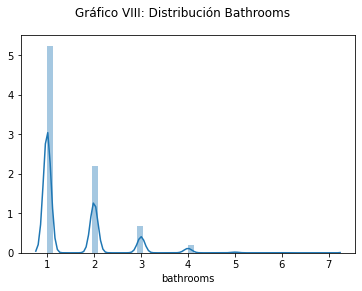

In [14]:
prop=prop[prop.rooms>=prop.bathrooms]
sns.distplot(prop.bathrooms)
plt.suptitle("Gráfico VIII: Distribución Bathrooms")

**Gráfico VIII:** los baños tienen distribución con cola hacia la derecha. La moda es uno.

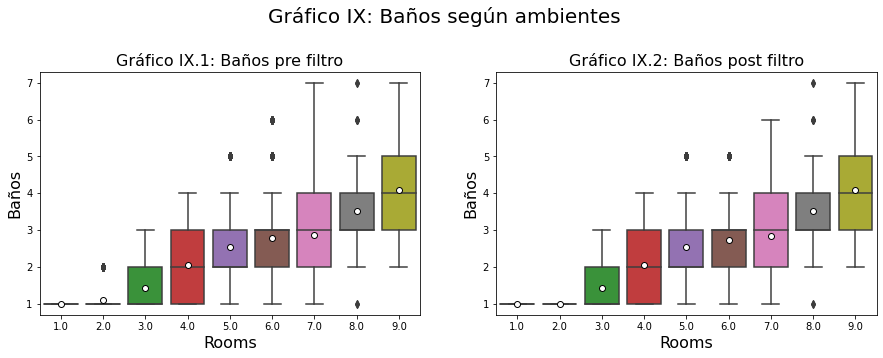

In [15]:
#6.Distribuciones y relaciones de a pares.

fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico IX: Baños según ambientes',fontsize=20, ha='center')

ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)


sns.boxplot(data = prop, y = "bathrooms",x='rooms',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

#aplico porque tengo más baños que ambientes
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)
prop= prop[~prop.groupby('rooms')['bathrooms'].apply(is_outlier)]

sns.boxplot(data = prop, y = "bathrooms",x='rooms',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)

ax1.set_title("Gráfico IX.1: Baños pre filtro",fontsize=16)
ax2.set_title("Gráfico IX.2: Baños post filtro",fontsize=16)

ax1.set_xlabel('Rooms',fontsize=16)
ax1.set_ylabel('Baños',fontsize=16)
ax2.set_xlabel('Rooms',fontsize=16)
ax2.set_ylabel('Baños',fontsize=16)

fig.subplots_adjust(top=0.80)

plt.show()

**Gráficos IX:**  

**- 1.** Se observan inconsistencias entre el número de baños y ambientes.
**- 2.** Se quitan las instancias mencionadas.

In [16]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_total,price
count,85724.000000,85724.000000,77191.000000,77485.000000,8.572400e+04
mean,2.933601,1.494471,93.204946,110.787120,2.455747e+05
std,1.189273,0.778012,802.834890,1011.536434,2.651746e+05
min,1.000000,1.000000,1.000000,10.000000,6.000000e+03
25%,2.000000,1.000000,44.000000,49.000000,1.200000e+05
50%,3.000000,1.000000,63.000000,71.000000,1.730000e+05
75%,4.000000,2.000000,95.000000,110.000000,2.700000e+05
max,9.000000,7.000000,126062.000000,126062.000000,6.500000e+06


# Surface Total eliminación de Outliers

In [17]:
#consistencia I
#realizaremos un filtro para poder interpretar la distribución
prop=prop[prop.surface_total<=750]

#consistencia II
prop=prop[prop.surface_covered<=prop.surface_total]

#se perdieron muchas instancias dado que no imputamos valores faltantes en superficie total y aplicamos una máscara
prop.shape

(76098, 7)

Text(0.5, 0.98, 'Gráfico X: Distrubición de Surface_Total')

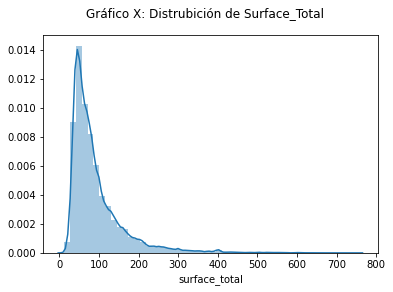

In [18]:
sns.distplot(prop.surface_total)
plt.suptitle("Gráfico X: Distrubición de Surface_Total")

- **Gráfico X:** en este caso hay una gran presencia de valores atipicos, para poder analizar se filtrarán aquellas propiedades con menos de 1000m2.
(previamente se verificó la existencia de solo 65 propiedades con esos valores, siendo la gran mayoria departamentos, lo cual es un claro indicador de que fueron mal tipeados, además los precios tampoco se corresponderían con dichas extensiones.)

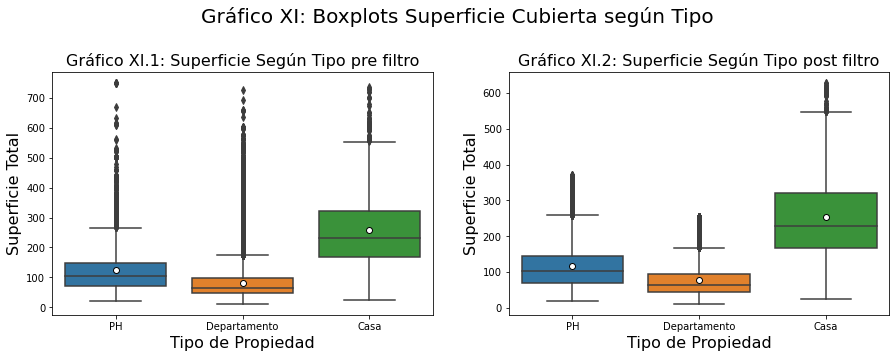

In [19]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XI: Boxplots Superficie Cubierta según Tipo',fontsize=20, ha='center')

ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

sns.boxplot(data = prop, y = "surface_total",x='property_type',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

#a simple vista notamos que hay demasiados departamentos con más de 2000 metros cuadrados
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

prop= prop[~prop.groupby('property_type')['surface_total'].apply(is_outlier)]


sns.boxplot(data = prop, y = "surface_total",x='property_type',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)

ax1.set_title("Gráfico XI.1: Superficie Según Tipo pre filtro",fontsize=16)
ax2.set_title("Gráfico XI.2: Superficie Según Tipo post filtro",fontsize=16)

ax1.set_xlabel('Tipo de Propiedad',fontsize=16)
ax1.set_ylabel('Superficie Total',fontsize=16)
ax2.set_xlabel('Tipo de Propiedad',fontsize=16)
ax2.set_ylabel('Superficie Total',fontsize=16)

fig.subplots_adjust(top=0.80)

plt.show()



**Gráficos XI:**

-1: Se realiza el boxplot sin outliers.

-2: Se muestra como quedan las distribuciones de superficie total según tipo. Después de quitar outliers

In [20]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_total,price
count,74478.000000,74478.000000,74478.000000,74478.000000,7.447800e+04
mean,2.926784,1.461237,75.357112,86.716413,2.293164e+05
std,1.134175,0.732981,46.520931,57.773182,1.922803e+05
min,1.000000,1.000000,1.000000,12.000000,6.000000e+03
25%,2.000000,1.000000,44.000000,48.000000,1.200000e+05
50%,3.000000,1.000000,62.000000,70.000000,1.740000e+05
75%,4.000000,2.000000,91.000000,105.000000,2.650000e+05
max,9.000000,7.000000,600.000000,628.000000,3.500000e+06


# Surface Discovered

Text(0.5, 0.98, 'Gráfico XII: Distribución de Superficie Descubierta')

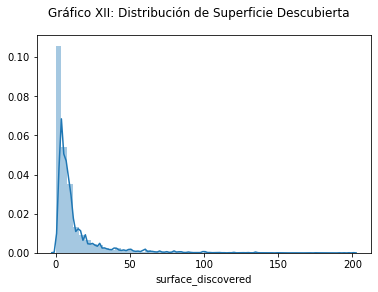

In [21]:
#new feature
prop['surface_discovered']=prop['surface_total'] - prop['surface_covered']

#inconsistencias
prop=prop[prop.surface_discovered<=prop.surface_covered]

prop['surface_total_int'] = pd.cut(prop.surface_total, bins  = 100)
prop['surface_covered_int'] = pd.cut(prop.surface_total, bins  = 100)

#reorganización de columnas
prop=prop[['rooms','bathrooms','surface_covered','surface_covered_int','surface_discovered','surface_total','surface_total_int','property_type','l3','price']]

prop=prop[prop.surface_discovered<=200]

sns.distplot(prop.surface_discovered)
plt.suptitle("Gráfico XII: Distribución de Superficie Descubierta")



**- Gráfico XII:** Se verifica nuevamente una distribución con cola hacia la derecha.

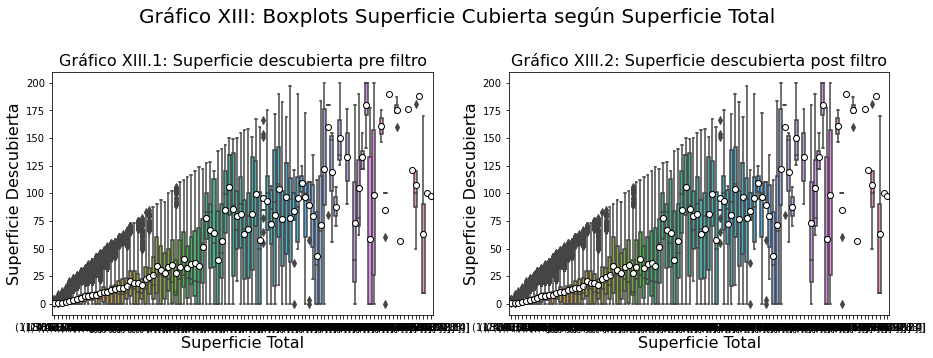

In [22]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XIII: Boxplots Superficie Cubierta según Superficie Total',fontsize=20, ha='center')

ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

sns.boxplot(data = prop, y = "surface_discovered",x='surface_total_int',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

#prop= prop[~prop.groupby('surface_total')['surface_discovered'].apply(is_outlier)]


sns.boxplot(data = prop, y = "surface_discovered",x='surface_total_int',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)

ax1.set_title("Gráfico XIII.1: Superficie descubierta pre filtro",fontsize=16)
ax2.set_title("Gráfico XIII.2: Superficie descubierta post filtro",fontsize=16)

ax1.set_xlabel('Superficie Total',fontsize=16)
ax1.set_ylabel('Superficie Descubierta',fontsize=16)
ax2.set_xlabel('Superficie Total',fontsize=16)
ax2.set_ylabel('Superficie Descubierta',fontsize=16)

fig.subplots_adjust(top=0.80)

plt.show()


**Gráficos XIII:**  

**- 1.** distribución antes de filtro.

**- 2.** distribución después del filtro.

In [23]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,price
count,73333.000000,73333.000000,73333.000000,73333.000000,73333.000000,7.333300e+04
mean,2.923854,1.462438,75.314811,9.945441,85.260251,2.290929e+05
std,1.132370,0.734258,46.347139,17.465318,55.337905,1.929132e+05
min,1.000000,1.000000,12.000000,0.000000,12.000000,6.000000e+03
25%,2.000000,1.000000,44.000000,0.000000,48.000000,1.200000e+05
50%,3.000000,1.000000,61.000000,5.000000,70.000000,1.730000e+05
75%,4.000000,2.000000,91.000000,10.000000,103.000000,2.650000e+05
max,9.000000,7.000000,600.000000,200.000000,628.000000,3.500000e+06


# Eliminación de Outliers SURFACE COVERED

Text(0.5, 0.98, 'Gráfico XVI: Distribución de Suerficie total')

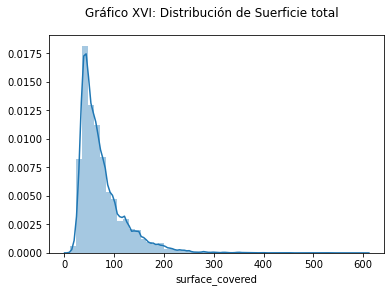

In [24]:
sns.distplot(prop.surface_covered)
plt.suptitle("Gráfico XVI: Distribución de Suerficie total")

**Gráfico XVI:** estamos ante una distribución asimétrica con pocos valores superiores a los 300mt2. Probablemente correspondientes a casas.

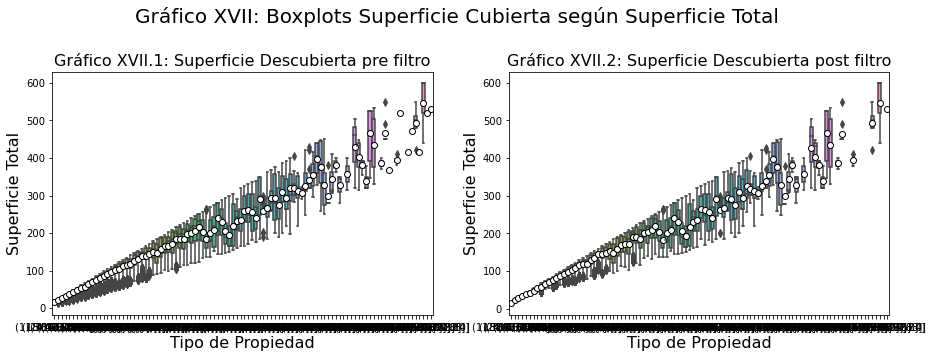

In [25]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XVII: Boxplots Superficie Cubierta según Superficie Total',fontsize=20, ha='center')

ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

sns.boxplot(data = prop, y = "surface_covered",x='surface_total_int',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

prop= prop[~prop.groupby('surface_total_int')['surface_covered'].apply(is_outlier)]


sns.boxplot(data = prop, y = "surface_covered",x='surface_total_int',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)

ax1.set_title("Gráfico XVII.1: Superficie Descubierta pre filtro",fontsize=16)
ax2.set_title("Gráfico XVII.2: Superficie Descubierta post filtro",fontsize=16)

ax1.set_xlabel('Tipo de Propiedad',fontsize=16)
ax1.set_ylabel('Superficie Total',fontsize=16)
ax2.set_xlabel('Tipo de Propiedad',fontsize=16)
ax2.set_ylabel('Superficie Total',fontsize=16)

fig.subplots_adjust(top=0.80)

plt.show()



**Gráficos XVII:**  

**- 1.** Se observan valores atípicos entre la superficie cubierta y la cantidad de habitaciones.

**- 2.** Se quitan las instancias mencionadas.

In [26]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,price
count,69823.000000,69823.000000,69823.000000,69823.000000,69823.000000,6.982300e+04
mean,2.948770,1.476992,76.408476,8.652264,85.060739,2.319351e+05
std,1.133784,0.743189,46.810227,15.969576,55.567136,1.962551e+05
min,1.000000,1.000000,13.000000,0.000000,13.000000,6.000000e+03
25%,2.000000,1.000000,44.000000,0.000000,48.000000,1.200000e+05
50%,3.000000,1.000000,63.000000,4.000000,69.000000,1.750000e+05
75%,4.000000,2.000000,94.000000,10.000000,102.000000,2.699000e+05
max,9.000000,7.000000,600.000000,200.000000,628.000000,3.500000e+06


# Price análisis de distribución y aproximación a quita de Outliers

Text(0.5, 0.98, 'Gráfico IXX: Distribución de Price')

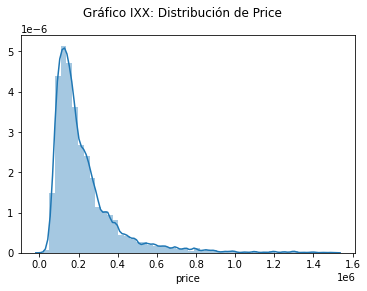

In [27]:
prop=prop[(prop.price>15000)&(prop.price<1500000)]
sns.distplot(prop.price)
plt.suptitle("Gráfico IXX: Distribución de Price")

**Gráfico IXX:** para asegurarnos representatividad en el análisis, quitaremos aquellas propiedades que cuesten más de 2millones de dólares.

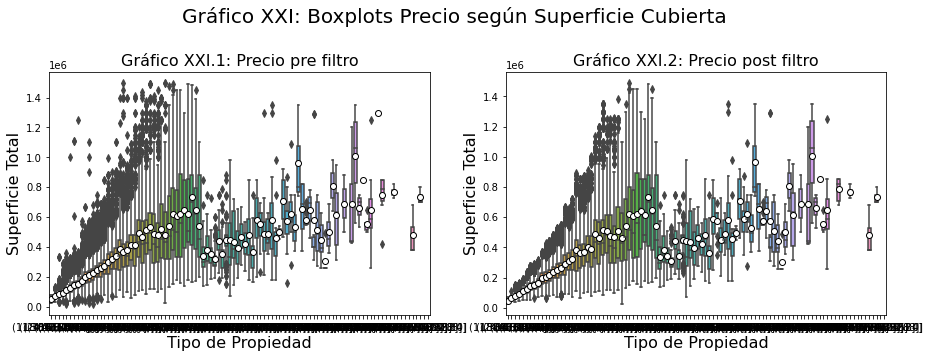

In [28]:
#6.Distribuciones y relaciones de a pares.

fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XXI: Boxplots Precio según Superficie Cubierta',fontsize=20, ha='center')

ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)


sns.boxplot(data = prop, y = "price",x='surface_covered_int',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

prop= prop[~prop.groupby('surface_covered_int')['price'].apply(is_outlier)]


sns.boxplot(data = prop, y = "price",x='surface_covered_int',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)

ax1.set_title("Gráfico XXI.1: Precio pre filtro",fontsize=16)
ax2.set_title("Gráfico XXI.2: Precio post filtro",fontsize=16)

ax1.set_xlabel('Tipo de Propiedad',fontsize=16)
ax1.set_ylabel('Superficie Total',fontsize=16)
ax2.set_xlabel('Tipo de Propiedad',fontsize=16)
ax2.set_ylabel('Superficie Total',fontsize=16)

fig.subplots_adjust(top=0.80)

plt.show()

In [29]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,price
count,68468.000000,68468.000000,68468.000000,68468.000000,68468.000000,6.846800e+04
mean,2.950955,1.469562,76.019849,8.689490,84.709339,2.236501e+05
std,1.132671,0.733946,46.163156,15.982317,55.001802,1.657743e+05
min,1.000000,1.000000,13.000000,0.000000,13.000000,2.700000e+04
25%,2.000000,1.000000,44.000000,0.000000,48.000000,1.200000e+05
50%,3.000000,1.000000,62.000000,4.000000,69.000000,1.730000e+05
75%,4.000000,2.000000,93.000000,10.000000,102.000000,2.650000e+05
max,9.000000,7.000000,600.000000,200.000000,610.000000,1.490000e+06


# -  ** New Features: Price_m2 y l3_enc**

Text(0.5, 0.98, 'Gráfico XX: Distribución de Precio por metro cuadrado')

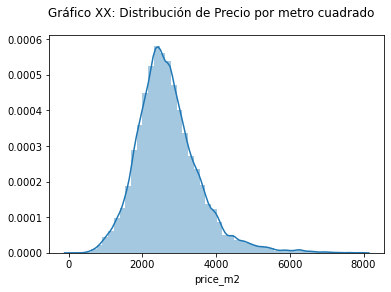

In [30]:
#new feature 1:
prop['price_m2'] = prop['price'] / prop['surface_total']
sns.distplot(prop.price_m2)
plt.suptitle("Gráfico XX: Distribución de Precio por metro cuadrado")

**Gráfico XX:** el valor mediano es de cerca de 2500 dólares y el valor máximo, de poco más de 8000.

In [31]:
#mapeo
grouped=prop.groupby('l3').mean().sort_values(('price_m2'),ascending=False).head(20)

#reorganizacion de columnas
prop=prop[['rooms','bathrooms','surface_covered','surface_discovered','surface_total','property_type','l3','price_m2','price']]

#mapeo
grouped=prop.groupby('l3').mean().sort_values(('price_m2'),ascending=False).head(20)
grouped

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,price_m2,price
l3,,,,,,,
Puerto Madero,3.228148,2.480000,129.118519,8.546667,137.665185,5163.018386,720705.377778
Las Cañitas,3.364173,2.165354,99.482283,9.974409,109.456693,3763.203072,421468.104331
Belgrano,3.103512,1.737648,85.989792,9.806860,95.796652,3295.375106,316644.014292
Palermo,2.893902,1.489043,75.619534,7.938027,83.557561,3281.408834,277073.984036
Recoleta,3.228774,1.667923,93.325205,6.217025,99.542230,3278.240882,325312.632232
Nuñez,2.851974,1.556579,75.735526,10.163158,85.898684,3210.499575,265135.188816
Barrio Norte,3.092681,1.561604,79.759838,6.168444,85.928282,3070.629704,262255.840382
Retiro,3.067976,1.673716,89.567976,4.176737,93.744713,2953.217348,277269.557402
Villa Urquiza,2.643688,1.336794,64.179402,10.178571,74.357973,2826.294975,199740.640781


In [32]:
#new_feature, l3_enc (precio por metro cuadrado promedio por barrio):
encod_type = prop.groupby('l3')['price_m2'].mean()
prop.loc[:, 'l3_enc'] = prop['l3'].map(encod_type)

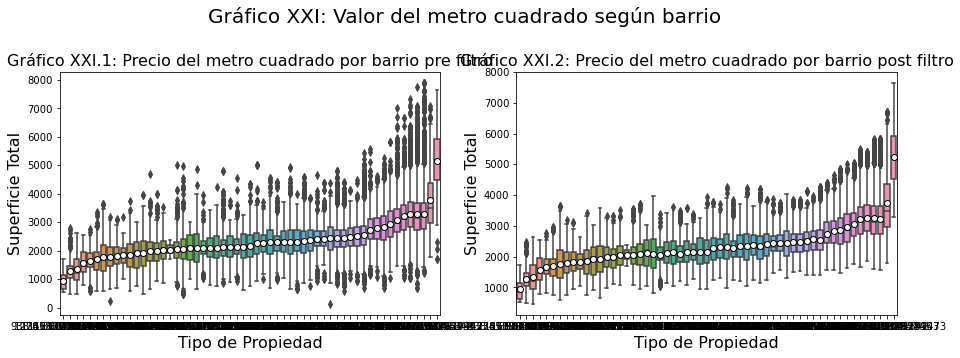

In [33]:
#6.Distribuciones y relaciones de a pares.

fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XXI: Valor del metro cuadrado según barrio',fontsize=20, ha='center')

ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)


sns.boxplot(data = prop, y = "price_m2",x='l3_enc',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

prop= prop[~prop.groupby('l3_enc')['price_m2'].apply(is_outlier)]


sns.boxplot(data = prop, y = "price_m2",x='l3_enc',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)

ax1.set_title("Gráfico XXI.1: Precio del metro cuadrado por barrio pre filtro",fontsize=16)
ax2.set_title("Gráfico XXI.2: Precio del metro cuadrado por barrio post filtro",fontsize=16)

ax1.set_xlabel('Tipo de Propiedad',fontsize=16)
ax1.set_ylabel('Superficie Total',fontsize=16)
ax2.set_xlabel('Tipo de Propiedad',fontsize=16)
ax2.set_ylabel('Superficie Total',fontsize=16)

fig.subplots_adjust(top=0.80)

plt.show()

In [34]:
prop.describe()

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,price_m2,price,l3_enc
count,67028.000000,67028.000000,67028.000000,67028.000000,67028.000000,67028.000000,6.702800e+04,67028.000000
mean,2.929045,1.456018,74.633705,8.175330,82.809035,2690.325121,2.191853e+05,2694.469500
std,1.119213,0.721744,44.335624,14.486556,52.120163,806.872036,1.554338e+05,559.428400
min,1.000000,1.000000,13.000000,0.000000,13.000000,467.741935,2.700000e+04,938.013386
25%,2.000000,1.000000,44.000000,0.000000,48.000000,2156.862745,1.200000e+05,2322.418625
50%,3.000000,1.000000,61.000000,4.000000,68.000000,2592.592593,1.700000e+05,2553.918912
75%,4.000000,2.000000,90.000000,9.000000,100.000000,3117.647059,2.600000e+05,3278.240882
max,9.000000,7.000000,600.000000,200.000000,610.000000,7647.058824,1.449000e+06,5163.018386


Text(0.5, 0.98, 'Gráfico XXII: Pairplot')

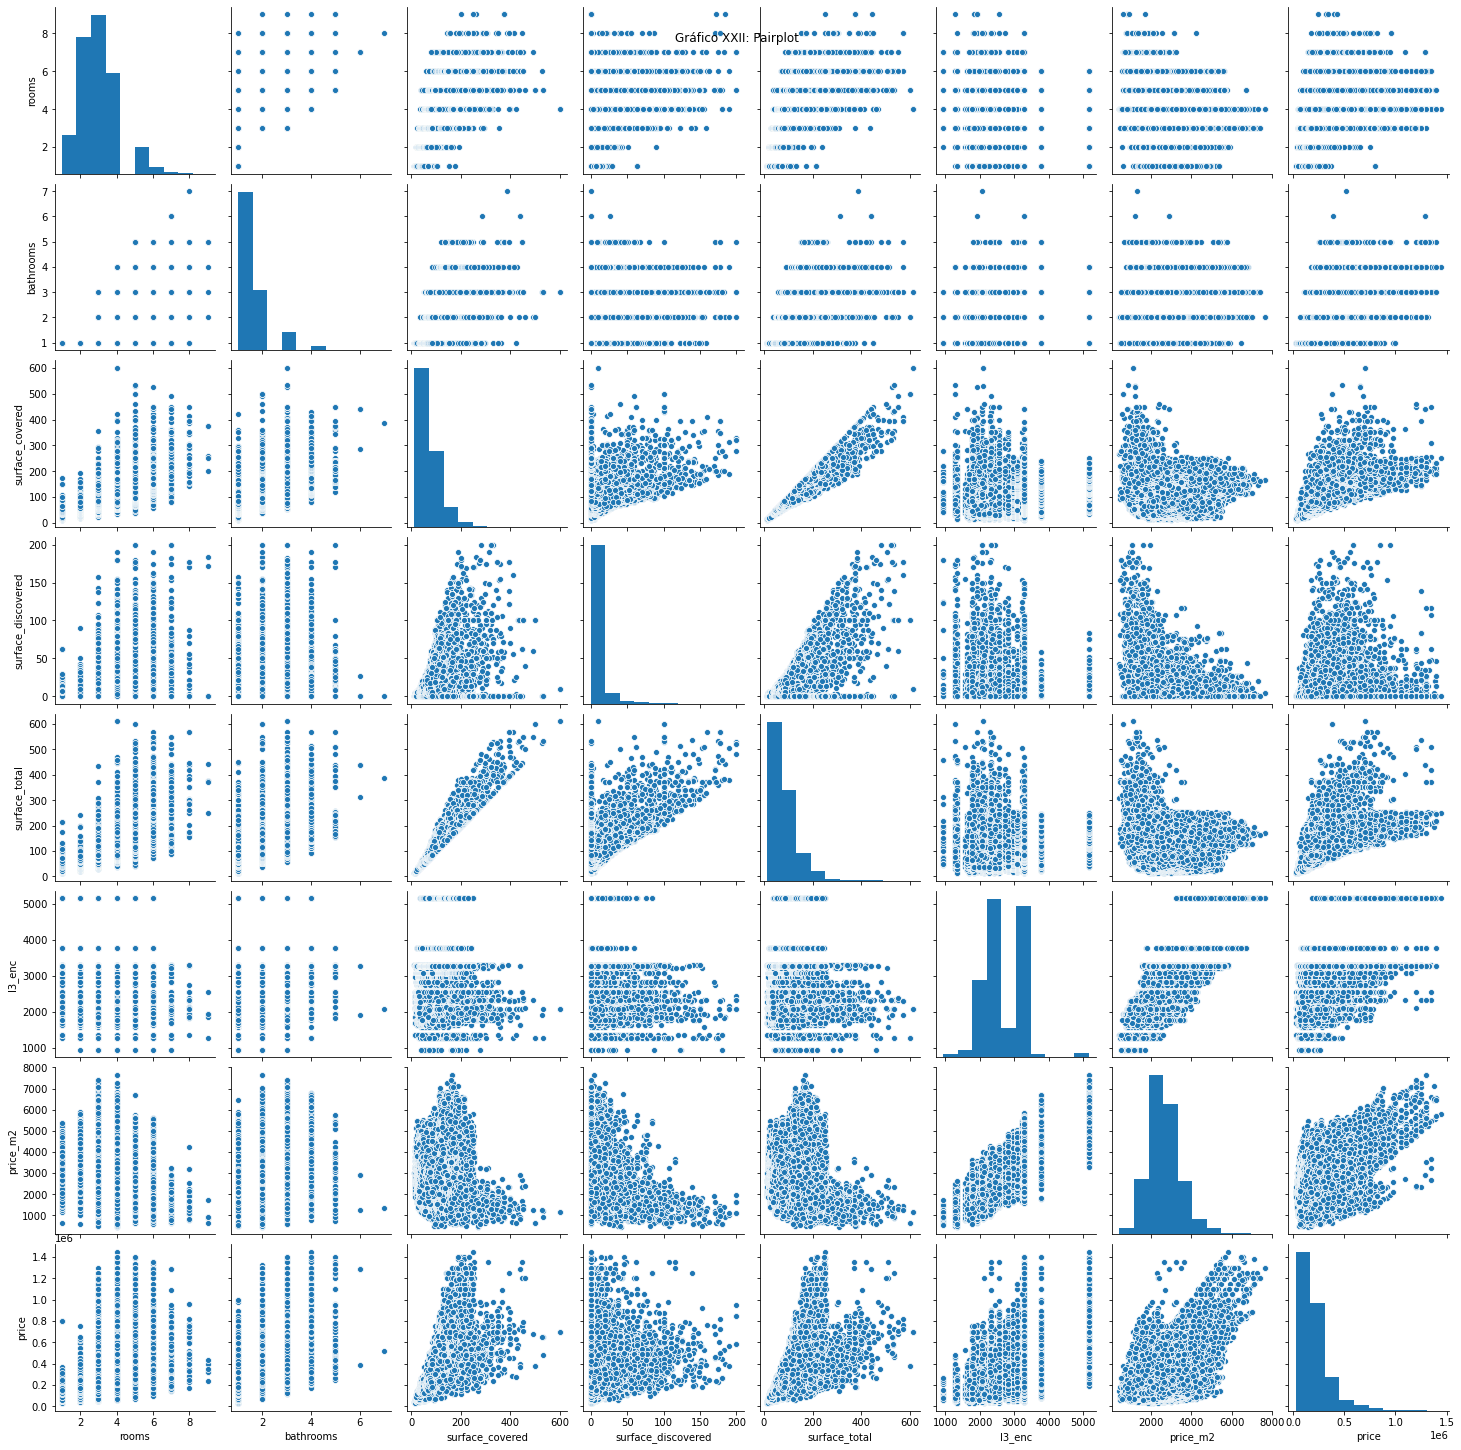

In [35]:
prop=prop[['rooms','bathrooms','surface_covered','surface_discovered','surface_total','l3','l3_enc','property_type','price_m2','price']]
sns.pairplot(prop)
plt.suptitle("Gráfico XXII: Pairplot")

**Gráfico XXII**: se observa que existe una fuerte correlación entre superficie total y superficie cubierta, siendo esta última la variable con mayor poder predictivo para determinar los precios.

# Encoding

Se realiza un one hot encoding para tipo de propiedad. Se imprimen también un describe y las correlaciones del dataset final.

In [36]:
#new feature 3:
prop['type'] = prop['property_type'] 
cat_columns=['type']
prop = pd.get_dummies(prop, prefix_sep="_", columns=cat_columns)

prop=prop[['rooms','bathrooms', 'surface_covered','surface_discovered','surface_total','property_type','type_Departamento','type_PH','type_Casa','l3','l3_enc','price_m2','price']]
prop.describe()

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,type_Departamento,type_PH,type_Casa,l3_enc,price_m2,price
count,67028.000000,67028.000000,67028.000000,67028.000000,67028.000000,67028.00000,67028.000000,67028.000000,67028.000000,67028.000000,6.702800e+04
mean,2.929045,1.456018,74.633705,8.175330,82.809035,0.87456,0.103643,0.021797,2694.469500,2690.325121,2.191853e+05
std,1.119213,0.721744,44.335624,14.486556,52.120163,0.33122,0.304799,0.146021,559.428400,806.872036,1.554338e+05
min,1.000000,1.000000,13.000000,0.000000,13.000000,0.00000,0.000000,0.000000,938.013386,467.741935,2.700000e+04
25%,2.000000,1.000000,44.000000,0.000000,48.000000,1.00000,0.000000,0.000000,2322.418625,2156.862745,1.200000e+05
50%,3.000000,1.000000,61.000000,4.000000,68.000000,1.00000,0.000000,0.000000,2553.918912,2592.592593,1.700000e+05
75%,4.000000,2.000000,90.000000,9.000000,100.000000,1.00000,0.000000,0.000000,3278.240882,3117.647059,2.600000e+05
max,9.000000,7.000000,600.000000,200.000000,610.000000,1.00000,1.000000,1.000000,5163.018386,7647.058824,1.449000e+06


In [37]:
prop.corr()

,rooms,bathrooms,surface_covered,surface_discovered,surface_total,type_Departamento,type_PH,type_Casa,l3_enc,price_m2,price
rooms,1.000000,0.617265,0.787220,0.348384,0.766475,-0.278485,0.183900,0.247822,0.034575,-0.116061,0.598212
bathrooms,0.617265,1.000000,0.687335,0.305586,0.669613,-0.091542,0.024553,0.156394,0.193448,0.131734,0.673549
surface_covered,0.787220,0.687335,1.000000,0.421165,0.967703,-0.304147,0.148354,0.380227,0.122761,-0.037938,0.788366
surface_discovered,0.348384,0.305586,0.421165,1.000000,0.636206,-0.304899,0.138489,0.402524,-0.044261,-0.191709,0.331879
surface_total,0.766475,0.669613,0.967703,0.636206,1.000000,-0.343465,0.164689,0.435317,0.092124,-0.085556,0.762862
type_Departamento,-0.278485,-0.091542,-0.304147,-0.304899,-0.343465,1.000000,-0.897856,-0.394148,0.195044,0.308842,-0.055126
type_PH,0.183900,0.024553,0.148354,0.138489,0.164689,-0.897856,1.000000,-0.050759,-0.153230,-0.246401,-0.012862
type_Casa,0.247822,0.156394,0.380227,0.402524,0.435317,-0.394148,-0.050759,1.000000,-0.122573,-0.186218,0.151892
l3_enc,0.034575,0.193448,0.122761,-0.044261,0.092124,0.195044,-0.153230,-0.122573,1.000000,0.679078,0.460904
price_m2,-0.116061,0.131734,-0.037938,-0.191709,-0.085556,0.308842,-0.246401,-0.186218,0.679078,1.000000,0.484923


# Variables Categóricas ex-post

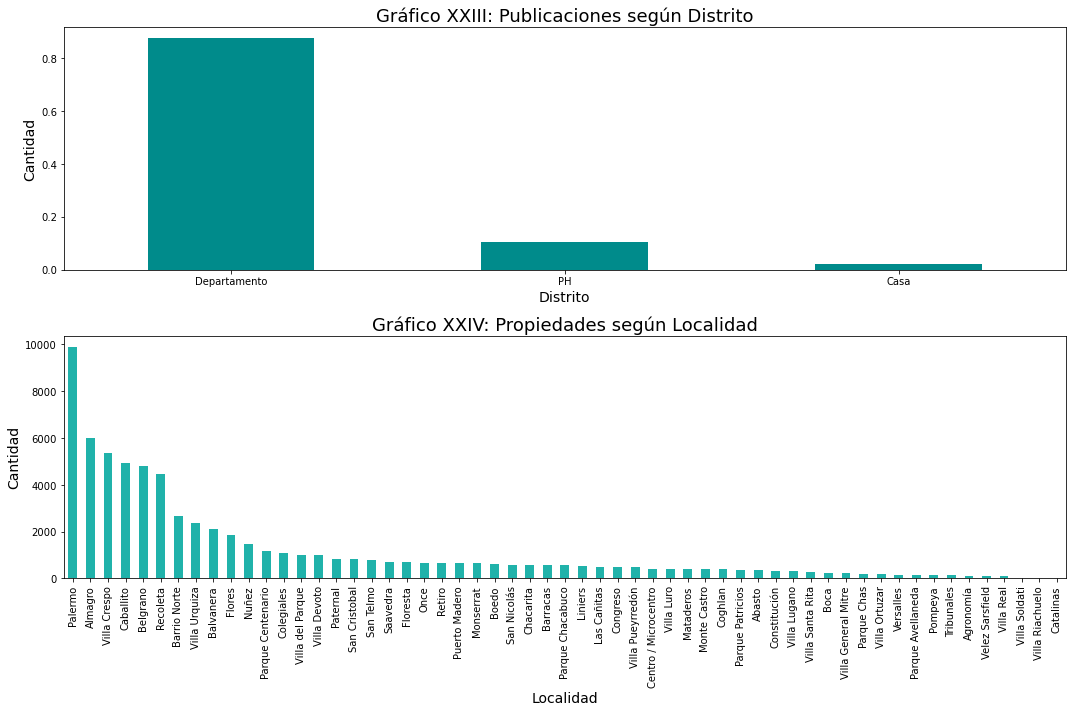

In [38]:
4. #Gráfico de barras de las publicaciones según región.
fig, axes = plt.subplots(figsize=(15,10),nrows=2, ncols=1)

sub1=prop['property_type'].value_counts(normalize=True).plot(ax=axes[0],kind='bar',color='darkcyan')
axes[0].set_title("Gráfico XXIII: Publicaciones según Distrito",fontsize=18)
axes[0].set_ylabel('Cantidad',fontsize=14)
axes[0].set_xlabel('Distrito',fontsize=14)
plt.setp(sub1.xaxis.get_majorticklabels(), rotation=0)

sub2=prop['l3'].value_counts().plot(ax=axes[1],kind='bar',color='lightseagreen')
axes[1].set_title("Gráfico XXIV: Propiedades según Localidad",fontsize=18)
axes[1].set_ylabel('Cantidad',fontsize=14)
axes[1].set_xlabel('Localidad',fontsize=14)

plt.tight_layout()
plt.show()

**Gráficos XXII y XXIII:** se finaliza con variables cualitativas muy similares a las del inicio, lo que es un buen indicador de que, tras las transformaciones realizadas, no se perdió representatividad: se mantuvo la proporción de casas y se conservaron los 57 barrios.

In [39]:
prop.l3.nunique()

57

# Vuelve a entrenar el modelo de la primera entrega

In [40]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#sk.metrics
from sklearn.metrics import mean_squared_error

#sk.model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


In [41]:
# ÁRBOL VIEJO CON DATASET NUEVO 
#variables
y=prop['price']
X=prop[['surface_covered','bathrooms']]
#train_Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# se instancia el modelo
tree_regressor = DecisionTreeRegressor(max_depth=8)

#se entrena
tree_regressor.fit(X_train, y_train)

modelos = ['Árbol de Decisión']

for i, model in enumerate([tree_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')


Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 82131.71377520308
Raíz del error cuadrático medio en Test: 84571.90904572942


Se visualiza una gran mejora, dado que el error en la primera entrega era:

Modelo: Árbol de Decisión

Raíz del error cuadrático medio en Train: 157823.33993549994

Raíz del error cuadrático medio en Test: 177801.87509168588v

# PARTE B - RandomForest

Argumentos por defecto.

In [42]:
#variables
y=prop['price']
X=prop[['surface_covered','l3_enc','surface_total','surface_discovered','bathrooms','rooms','type_Departamento','type_PH','type_Casa']]

#train_Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)
preds_test = rf_model.predict(X_test)
preds_train=rf_model.predict(X_train)
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
rmse_train=np.sqrt(mean_squared_error(y_train,preds_train))
print("RMSE: %f" % (rmse_train))
print("RMSE: %f" % (rmse_test))


RMSE: 20198.378860
RMSE: 41656.995432


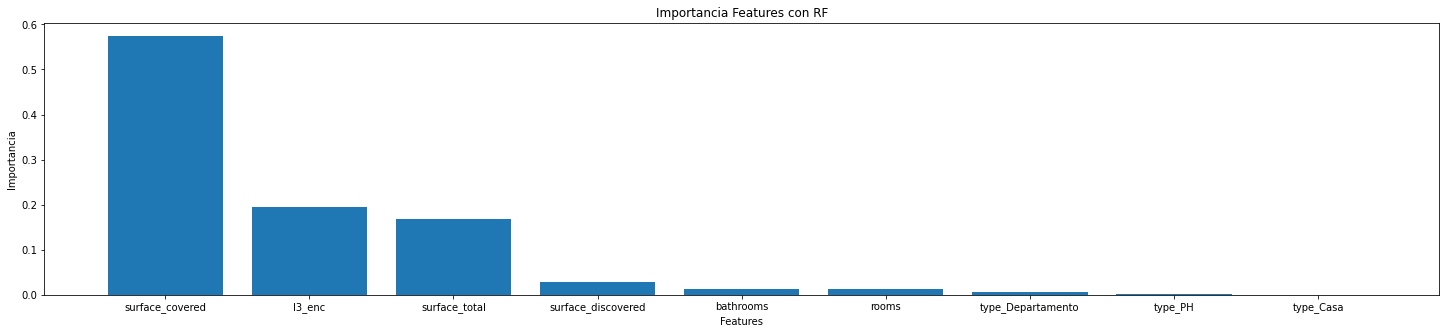

In [43]:
# Gini importance train
rf_model.feature_importances_
plt.figure(figsize=(25,5))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [44]:
#variables
y=prop['price']
X=prop[['surface_covered','l3_enc','surface_total','surface_discovered','bathrooms','rooms','type_Departamento','type_PH']]

**Optimización de hiperparámetros mediante random search:**
- Dado que previamente se estudió el árbol simple, ya se contaba con una idea de la profundidad máxima a adoptar para evitar el overfitting.

- El número de árboles es la característica principal para este modelo, se estableció el rango 15-30 después de realizar varias pruebas y no obtener mejores resultados al incorporar nuevos árboles.

- La cantidad mínima de atributos para realizar un split y la cantidad mínima para cada hoja se utilizan para evitar el overfitting.

- Para la cantidad máxima de features se probará el total y la raiz del total de features.

In [45]:
from pprint import pprint

import pprint
# Randomized Search 

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(7,8 , num = 2)]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 15, stop = 30, num = 10)]

# Number of features to consider at every split
max_features = ['auto','sqrt']

# max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2,3]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]

# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint.pprint(random_grid)

{'max_depth': [7, 8],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3],
 'n_estimators': [15, 16, 18, 20, 21, 23, 25, 26, 28, 30]}


In [46]:
rf=RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter = 60, cv = 5, verbose=2, random_state=42, n_jobs = 1)
rf_random.fit(X_train, y_train)
print("Mejores parametros: "+str(rf_random.best_params_))
print("Mejor Score: "+str(rf_random.best_score_)+'\n')
#scores = pd.DataFrame(rf_random.cv_results_)
#scores

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=21, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7, total=   0.7s
[CV] n_estimators=25, min_samples_split=2, min_samples_leaf=1, max_fea

[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7, total=   0.8s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7, total=   0.8s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7, total=   0.8s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=7, total=   0.8s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, total=   0.6s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_fea

[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=   0.3s
[CV] n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=   0.3s
[CV] n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=   0.3s
[CV] n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=   0.3s
[CV] n_estimators=23, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=7 
[CV]  n_estimators=23, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=23, min_samples_split=3, min_samples_leaf=1, max_fea

[CV]  n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8, total=   0.7s
[CV] n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8 
[CV]  n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8, total=   0.7s
[CV] n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8 
[CV]  n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8, total=   0.7s
[CV] n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8 
[CV]  n_estimators=25, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=8, total=   0.7s
[CV] n_estimators=15, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=8 
[CV]  n_estimators=15, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=8, total=   0.5s
[CV] n_estimators=15, min_samples_split=3, min_samples_leaf=2, max_fea

[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.6s
[CV] n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.8s
[CV] n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.7s
[CV] n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=23, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=7, total=   0.7s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8 
[CV]  n_estimators=18, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=8, total=   0.2s
[CV] n_estimators=18, min_samples_split=2, min_samples_leaf=1, max_fea

[CV]  n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   0.4s
[CV] n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   0.4s
[CV] n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   0.3s
[CV] n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=26, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8, total=   0.4s
[CV] n_estimators=18, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=18, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.2s
[CV] n_estimators=18, min_samples_split=3, min_samples_leaf=4, max_fea

[CV]  n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8, total=   1.0s
[CV] n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8 
[CV]  n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8, total=   0.9s
[CV] n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8 
[CV]  n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8, total=   1.0s
[CV] n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8 
[CV]  n_estimators=30, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=8, total=   0.9s
[CV] n_estimators=15, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=7 
[CV]  n_estimators=15, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=7, total=   0.2s
[CV] n_estimators=15, min_samples_split=2, min_samples_leaf=1, max_fea

[CV]  n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=23, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.3s
[CV] n_estimators=30, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=8 
[CV]  n_estimators=30, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=8, total=   0.4s
[CV] n_estimators=30, min_samples_split=3, min_samples_leaf=2, max_fea

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.4min finished


Mejores parametros: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8}
Mejor Score: 0.8768534806340542



In [47]:
#train_Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

rf_model = RandomForestRegressor(n_estimators=25,
                                 criterion='mse', max_depth=8, min_samples_split=3, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                 max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                 min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
                                 random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)


rf_model_rmse=cross_val_score(rf_model,X,y,cv=10,scoring='neg_root_mean_squared_error')

rf_model.fit(X_train, y_train)

#predecimos sobre el set de entrenamiento
y_train_pred = rf_model.predict(X_train)

#predecimos sobre el set de test
y_test_pred=rf_model.predict(X_test)


Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 52012.0265821032
Raíz del error cuadrático medio en Test: 54054.35842305723


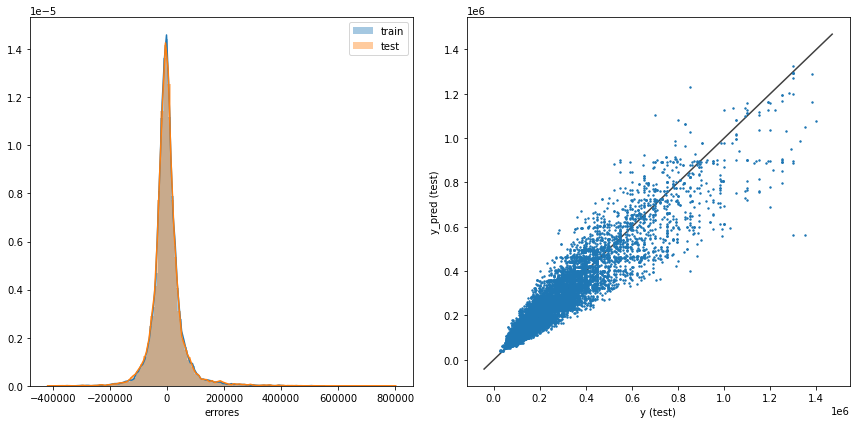

In [48]:

modelos = ['Árbol de Decisión']

for i, model in enumerate([rf_model]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (12,6))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 100, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 100, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()
    

**PARTE C - Interpretación RandomForest**

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

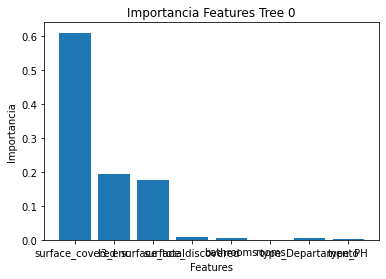

In [49]:
tree0 = rf_model.estimators_[0]
plt.bar(X_train.columns, tree0.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features Tree 0')
plt.show()

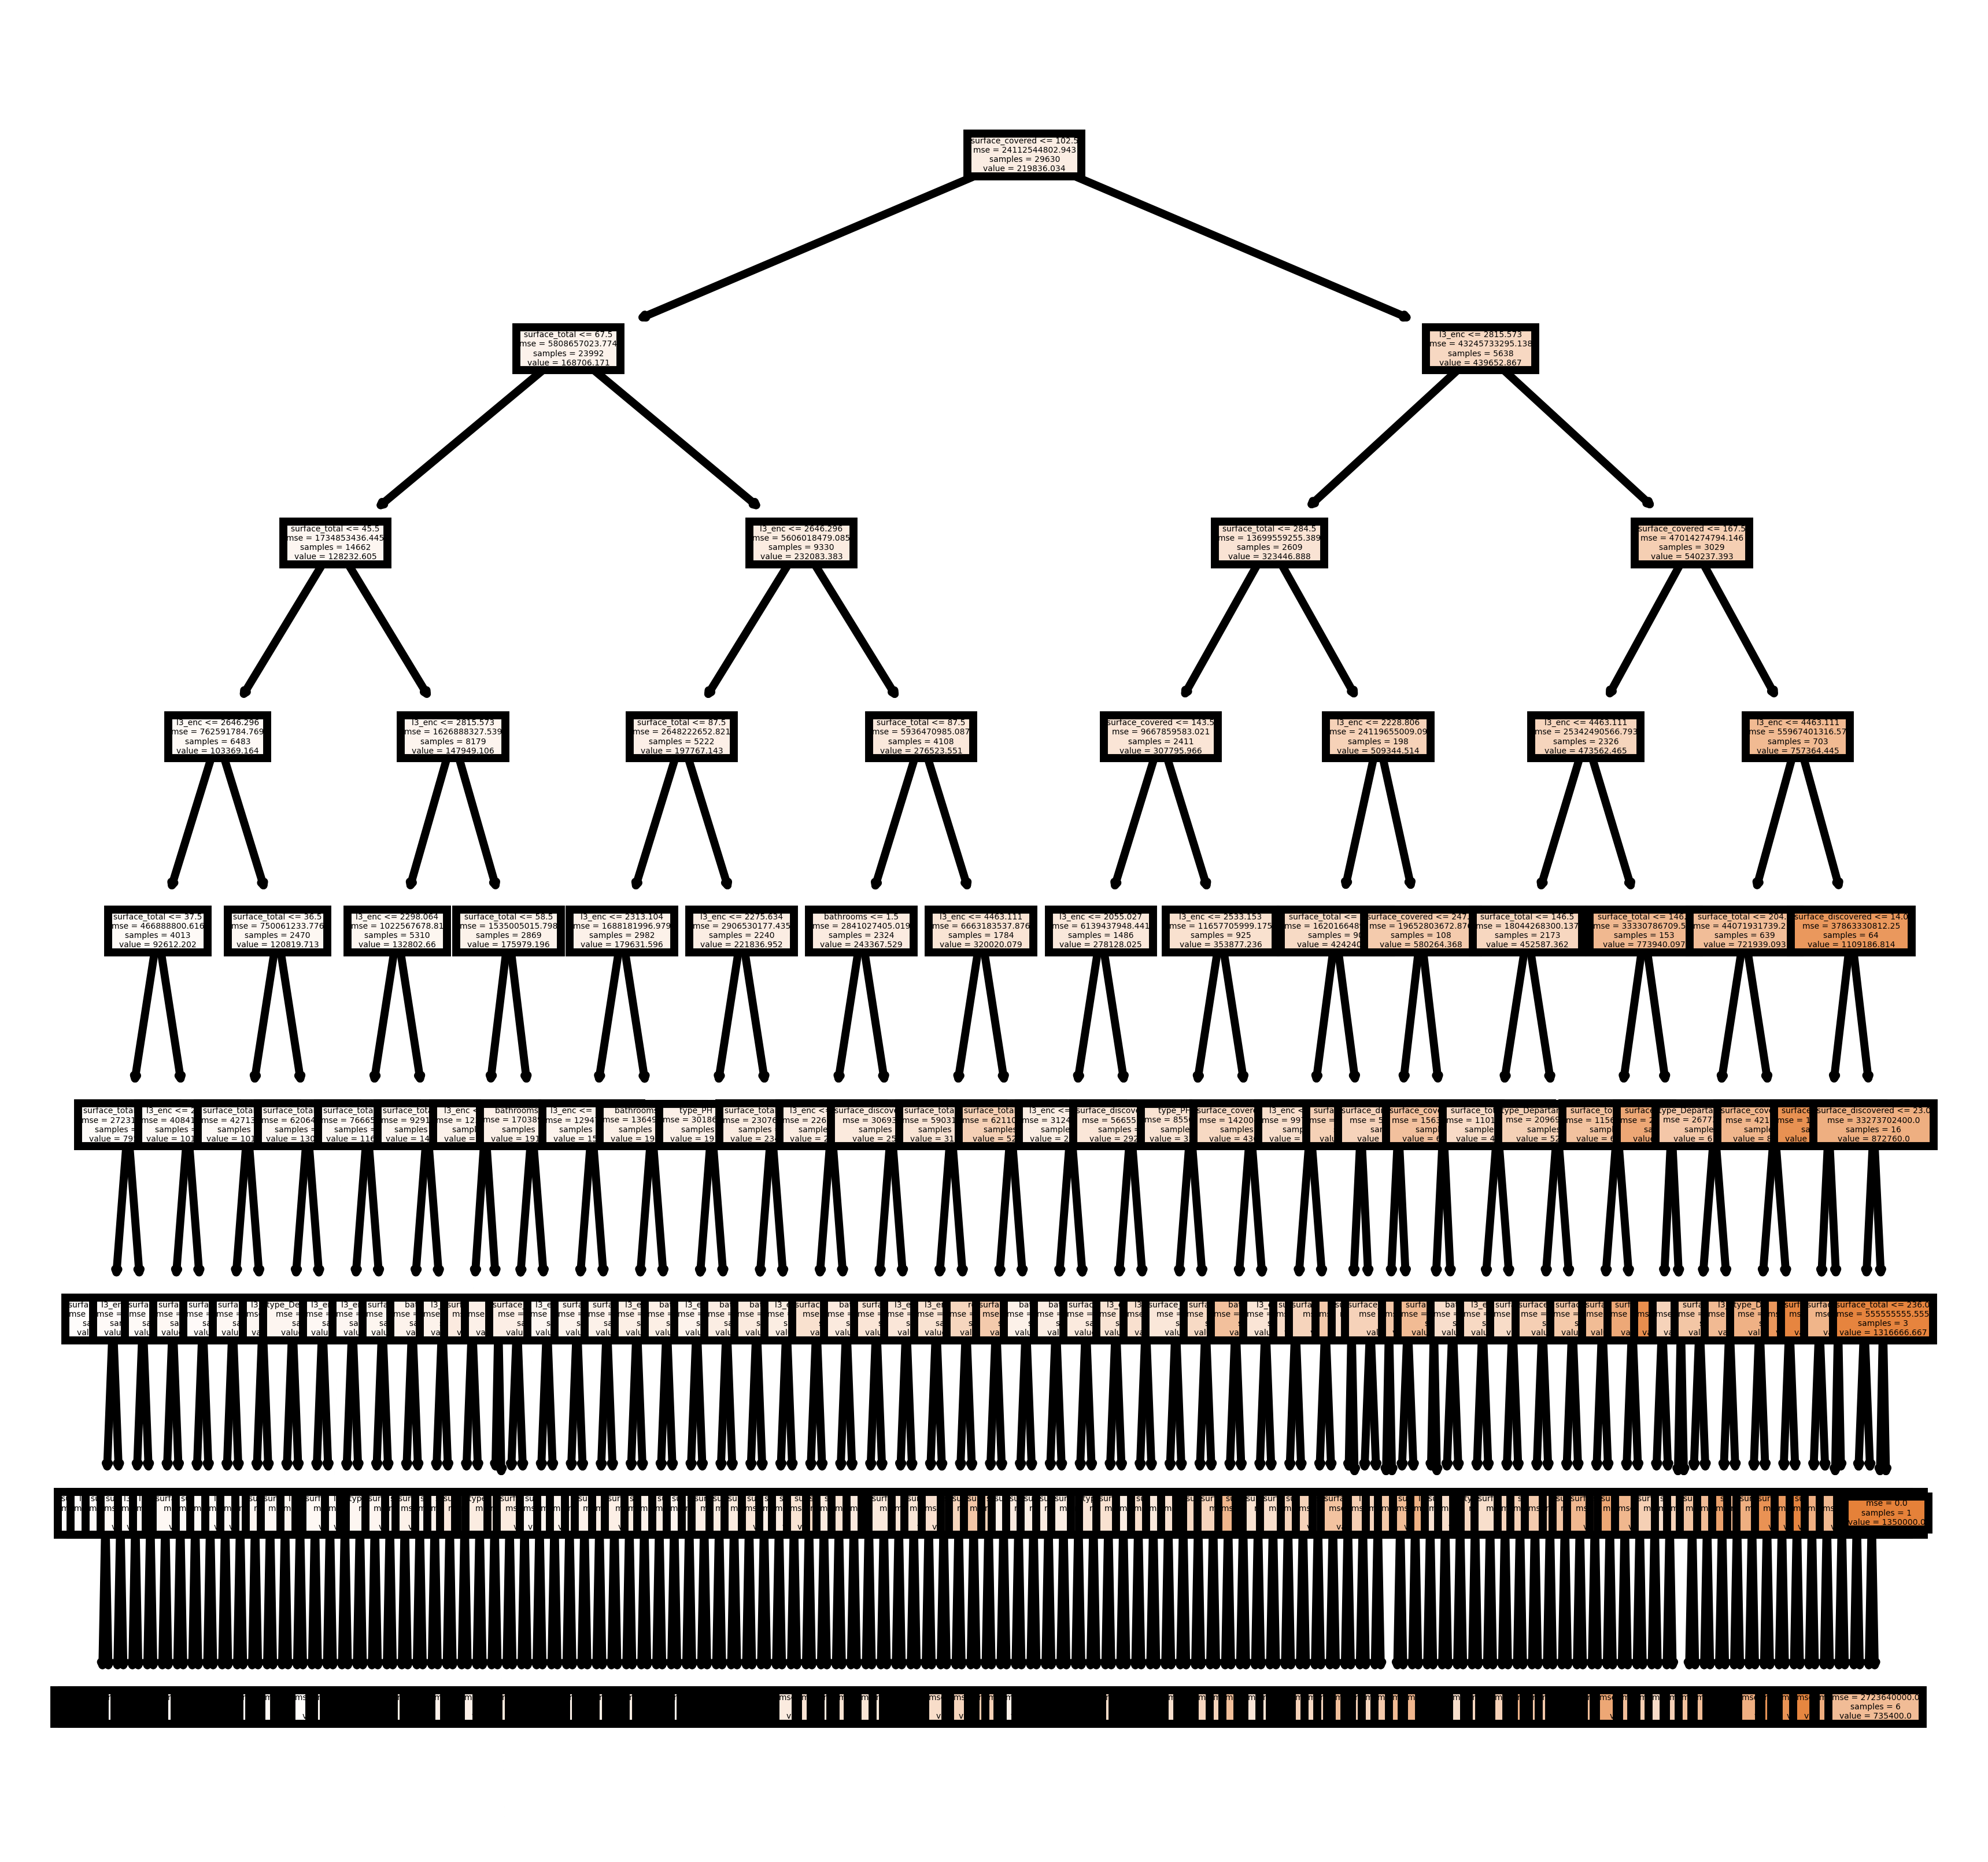

In [50]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
tree.plot_tree(tree0,
               feature_names = X_train.columns,
               filled = True);

Las **variables más importantes**para determinar el precio son la superficie cubierta, el barrio y la superficie total. Coincide parcialmente con lo que esperaba, dado que esperaba que el modelo le de mayor importancia a superficie total que a superficie descubierta (esperaba lo contrario dado qeu esta última está menos correlacionada con superficie cubierta). En los árboles individuales se les da a las variables más importantes presencia en los nodos superiores.      

¿Cómo es la **distribución de errores** (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

Los errores se distribuyen de una manera aproximadamente normal, sin embargo se observa un pequeño sesgo hacia la derecha, lo que indica que, en el caso de que el precio sea demasiado alto, el modelo tiende a indicar un precio menor. Esto se puede deber a que para las propiedades más caras existen factores que exceden al modelo como pueden ser la presencia de garage, pileta, etc.

# PARTE B (bis) - XGBoost

Entrenamiento y evaluación con sus argumentos por defecto.

In [51]:
y=prop['price']
X=prop[['rooms','bathrooms', 'surface_covered',
'surface_discovered','surface_total','type_Departamento','type_PH',
 'type_Casa','l3_enc']]

#train_Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train)
preds_test = xg_reg.predict(X_test)
preds_train=xg_reg.predict(X_train)
#train
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
print("RMSE train: %f" % (rmse_train))

#metrica test
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
print("RMSE test: %f" % (rmse_test))

[13:06:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE train: 54056.220048
RMSE test: 55643.386325


**Óptimización de Hiperparámetros:**
- Para la profundidad máxima se ensayaron valores más pequeños que para fandom forest, dada la naturaleza de este tipo de ensambles.

- El número de árboles a probar tendrá un rango mayor que en caso anterior.

- En la tasa de aprendizaje se utilizará un valor máximo de 0.25 para evitar el overfitting.

- Finalmente, para la regularización se utilizará un rango del 1 al 10.

In [52]:
from pprint import pprint

import pprint
# Randomized Search CV

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3,4, num = 2)]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

# Number of features to consider at every split
learning_rate= [0.1,0.125,0.25,0.375,0.5]

# max_depth.append(None)

# Minimum number of samples required to split a node
colsample_bytree = [float(x) for x in np.linspace(0,1 , num = 10)]

gamma=[0,1,3,5,10,50,100,500,1000]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree,
               'gamma': gamma}

pprint.pprint(random_grid)

{'colsample_bytree': [0.0,
                      0.1111111111111111,
                      0.2222222222222222,
                      0.3333333333333333,
                      0.4444444444444444,
                      0.5555555555555556,
                      0.6666666666666666,
                      0.7777777777777777,
                      0.8888888888888888,
                      1.0],
 'gamma': [0, 1, 3, 5, 10, 50, 100, 500, 1000],
 'learning_rate': [0.1, 0.125, 0.25, 0.375, 0.5],
 'max_depth': [3, 4],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [53]:
folds = 3
param_comb = 5

xg_reg=xgb.XGBRegressor()
xg_random = RandomizedSearchCV(estimator = xg_reg, param_distributions=random_grid, n_iter = 60, cv = 5, verbose=2, random_state=42, n_jobs = 1)
xg_random.fit(X_train, y_train)
print("Mejores parametros: "+str(xg_random.best_params_))
print("Mejor Score: "+str(xg_random.best_score_)+'\n')
print('\n All results:')
print(xg_random.cv_results_)
print('\n Best estimator:')
print(xg_random.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(xg_random.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(xg_random.best_params_)
results = pd.DataFrame(xg_random.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888 
[13:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888, total=   0.1s
[CV] n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888 
[13:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888, total=   0.1s
[CV] n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888 
[13:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888, total=   0.1s
[CV] n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888 
[13:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888, total=   0.1s
[CV] n_estimators=10, max_depth=4, learning_rate=0.375, gamma=0, colsample_bytree=0.8888888888888888 
[13:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squareder

[CV]  n_estimators=60, max_depth=3, learning_rate=0.375, gamma=1000, colsample_bytree=0.6666666666666666, total=   0.4s
[CV] n_estimators=60, max_depth=3, learning_rate=0.375, gamma=1000, colsample_bytree=0.6666666666666666 
[13:06:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=3, learning_rate=0.375, gamma=1000, colsample_bytree=0.6666666666666666, total=   0.4s
[CV] n_estimators=60, max_depth=3, learning_rate=0.375, gamma=1000, colsample_bytree=0.6666666666666666 
[13:06:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=3, learning_rate=0.375, gamma=1000, colsample_bytree=0.6666666666666666, total=   0.4s
[CV] n_estimators=60, max_depth=3, learning_rate=0.375, gamma=1000, colsample_bytree=0.6666666666666666 
[13:06:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favo

[CV]  n_estimators=60, max_depth=3, learning_rate=0.5, gamma=500, colsample_bytree=0.1111111111111111, total=   0.2s
[CV] n_estimators=60, max_depth=3, learning_rate=0.5, gamma=500, colsample_bytree=0.1111111111111111 
[13:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=3, learning_rate=0.5, gamma=500, colsample_bytree=0.1111111111111111, total=   0.2s
[CV] n_estimators=60, max_depth=3, learning_rate=0.5, gamma=500, colsample_bytree=0.1111111111111111 
[13:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=3, learning_rate=0.5, gamma=500, colsample_bytree=0.1111111111111111, total=   0.2s
[CV] n_estimators=100, max_depth=3, learning_rate=0.375, gamma=500, colsample_bytree=0.0 
[13:06:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n

[CV] n_estimators=20, max_depth=4, learning_rate=0.25, gamma=50, colsample_bytree=0.5555555555555556 
[13:06:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=20, max_depth=4, learning_rate=0.25, gamma=50, colsample_bytree=0.5555555555555556, total=   0.2s
[CV] n_estimators=20, max_depth=4, learning_rate=0.25, gamma=50, colsample_bytree=0.5555555555555556 
[13:06:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=20, max_depth=4, learning_rate=0.25, gamma=50, colsample_bytree=0.5555555555555556, total=   0.2s
[CV] n_estimators=10, max_depth=3, learning_rate=0.125, gamma=1, colsample_bytree=0.7777777777777777 
[13:06:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=10, max_depth=3, learning_rate=0.125, gamma=1, colsample_bytree=0.7777777777777777, total=   

[CV]  n_estimators=70, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.7777777777777777, total=   0.6s
[CV] n_estimators=70, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.7777777777777777 
[13:07:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=70, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.7777777777777777, total=   0.6s
[CV] n_estimators=70, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.7777777777777777 
[13:07:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=70, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.7777777777777777, total=   0.6s
[CV] n_estimators=70, max_depth=3, learning_rate=0.375, gamma=50, colsample_bytree=1.0 
[13:07:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=

[CV]  n_estimators=80, max_depth=3, learning_rate=0.25, gamma=0, colsample_bytree=0.3333333333333333, total=   0.4s
[CV] n_estimators=80, max_depth=3, learning_rate=0.25, gamma=0, colsample_bytree=0.3333333333333333 
[13:07:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, max_depth=3, learning_rate=0.25, gamma=0, colsample_bytree=0.3333333333333333, total=   0.4s
[CV] n_estimators=80, max_depth=3, learning_rate=0.25, gamma=0, colsample_bytree=0.3333333333333333 
[13:07:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=80, max_depth=3, learning_rate=0.25, gamma=0, colsample_bytree=0.3333333333333333, total=   0.4s
[CV] n_estimators=100, max_depth=3, learning_rate=0.5, gamma=1, colsample_bytree=0.0 
[13:07:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimato

[CV]  n_estimators=100, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.2222222222222222, total=   0.5s
[CV] n_estimators=100, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.2222222222222222 
[13:07:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=100, max_depth=4, learning_rate=0.5, gamma=0, colsample_bytree=0.2222222222222222, total=   0.5s
[CV] n_estimators=50, max_depth=4, learning_rate=0.125, gamma=50, colsample_bytree=0.8888888888888888 
[13:07:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=50, max_depth=4, learning_rate=0.125, gamma=50, colsample_bytree=0.8888888888888888, total=   0.5s
[CV] n_estimators=50, max_depth=4, learning_rate=0.125, gamma=50, colsample_bytree=0.8888888888888888 
[13:07:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squareder

[CV]  n_estimators=10, max_depth=4, learning_rate=0.5, gamma=3, colsample_bytree=0.4444444444444444, total=   0.1s
[CV] n_estimators=10, max_depth=4, learning_rate=0.5, gamma=3, colsample_bytree=0.4444444444444444 
[13:07:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=10, max_depth=4, learning_rate=0.5, gamma=3, colsample_bytree=0.4444444444444444, total=   0.1s
[CV] n_estimators=90, max_depth=4, learning_rate=0.125, gamma=500, colsample_bytree=1.0 
[13:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=90, max_depth=4, learning_rate=0.125, gamma=500, colsample_bytree=1.0, total=   0.9s
[CV] n_estimators=90, max_depth=4, learning_rate=0.125, gamma=500, colsample_bytree=1.0 
[13:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=90, max_depth=4, lear

[CV]  n_estimators=40, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.8888888888888888, total=   0.4s
[CV] n_estimators=30, max_depth=4, learning_rate=0.1, gamma=1000, colsample_bytree=0.2222222222222222 
[13:07:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=30, max_depth=4, learning_rate=0.1, gamma=1000, colsample_bytree=0.2222222222222222, total=   0.2s
[CV] n_estimators=30, max_depth=4, learning_rate=0.1, gamma=1000, colsample_bytree=0.2222222222222222 
[13:07:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=30, max_depth=4, learning_rate=0.1, gamma=1000, colsample_bytree=0.2222222222222222, total=   0.2s
[CV] n_estimators=30, max_depth=4, learning_rate=0.1, gamma=1000, colsample_bytree=0.2222222222222222 
[13:07:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

[CV]  n_estimators=100, max_depth=4, learning_rate=0.5, gamma=500, colsample_bytree=0.7777777777777777, total=   0.8s
[CV] n_estimators=60, max_depth=4, learning_rate=0.375, gamma=500, colsample_bytree=0.0 
[13:07:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=4, learning_rate=0.375, gamma=500, colsample_bytree=0.0, total=   0.3s
[CV] n_estimators=60, max_depth=4, learning_rate=0.375, gamma=500, colsample_bytree=0.0 
[13:07:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=4, learning_rate=0.375, gamma=500, colsample_bytree=0.0, total=   0.3s
[CV] n_estimators=60, max_depth=4, learning_rate=0.375, gamma=500, colsample_bytree=0.0 
[13:08:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=4, learning_rate=0.375, ga

[CV]  n_estimators=60, max_depth=4, learning_rate=0.25, gamma=5, colsample_bytree=0.8888888888888888, total=   0.6s
[CV] n_estimators=60, max_depth=4, learning_rate=0.25, gamma=5, colsample_bytree=0.8888888888888888 
[13:08:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=4, learning_rate=0.25, gamma=5, colsample_bytree=0.8888888888888888, total=   0.6s
[CV] n_estimators=60, max_depth=4, learning_rate=0.25, gamma=5, colsample_bytree=0.8888888888888888 
[13:08:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=60, max_depth=4, learning_rate=0.25, gamma=5, colsample_bytree=0.8888888888888888, total=   0.6s
[CV] n_estimators=60, max_depth=4, learning_rate=0.25, gamma=5, colsample_bytree=0.8888888888888888 
[13:08:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[

[CV]  n_estimators=40, max_depth=4, learning_rate=0.375, gamma=50, colsample_bytree=0.7777777777777777, total=   0.4s
[CV] n_estimators=40, max_depth=4, learning_rate=0.375, gamma=50, colsample_bytree=0.7777777777777777 
[13:08:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=40, max_depth=4, learning_rate=0.375, gamma=50, colsample_bytree=0.7777777777777777, total=   0.4s
[CV] n_estimators=40, max_depth=4, learning_rate=0.375, gamma=50, colsample_bytree=0.7777777777777777 
[13:08:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=40, max_depth=4, learning_rate=0.375, gamma=50, colsample_bytree=0.7777777777777777, total=   0.4s
[CV] n_estimators=40, max_depth=4, learning_rate=0.375, gamma=50, colsample_bytree=0.7777777777777777 
[13:08:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.9min finished


Mejores parametros: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 500, 'colsample_bytree': 0.7777777777777777}
Mejor Score: 0.8903719993704122


 All results:
{'mean_fit_time': array([0.12826991, 0.06402917, 0.10552554, 0.17316208, 0.4328537 ,
       0.39516578, 0.26132083, 0.39317565, 0.69396338, 0.26063123,
       0.22899847, 0.35487676, 0.6572567 , 0.22761025, 0.17834144,
       0.1781302 , 0.09974999, 0.19909091, 0.44697909, 0.30342107,
       0.57647982, 0.52940965, 0.47654009, 0.69591093, 0.35864801,
       0.39979806, 0.35268016, 0.32136059, 0.31596956, 0.63490858,
       0.50207653, 0.47833419, 0.28965406, 0.32455058, 0.4294621 ,
       0.09855995, 0.870683  , 0.30081329, 0.30519733, 0.41390896,
       0.39475942, 0.19089541, 0.16177897, 0.48911667, 0.43644538,
       0.83437643, 0.26830835, 0.57905374, 0.20387487, 0.22622476,
       0.23297915, 0.54594712, 0.26589408, 0.09515758, 0.25332217,
       0.70092654, 0.36323056, 0.47617345, 0.09495263, 0.540565

In [54]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.777777777,
          'learning_rate': 0.5, 'max_depth': 4, 'alpha': 10,'gamma':500 ,'n_estimators':100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
cv_results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,147666.750000,506.333578,147804.651042,1474.702699
1,93325.890625,1545.596350,93431.963541,292.458046
2,70281.489583,497.292249,70586.773438,1047.773820
3,62047.662760,263.587704,62568.867188,1062.987923
4,59241.774740,100.872161,59789.119792,933.748925


In [55]:
print((cv_results["train-rmse-mean"]).tail(1))
print((cv_results["test-rmse-mean"]).tail(1))

49    49364.061198
Name: train-rmse-mean, dtype: float64
49    52787.736979
Name: test-rmse-mean, dtype: float64


Realizaremos el gráfico (el modelo entrenado para el gráfico no incluye el cross validation)

Modelo: xgb


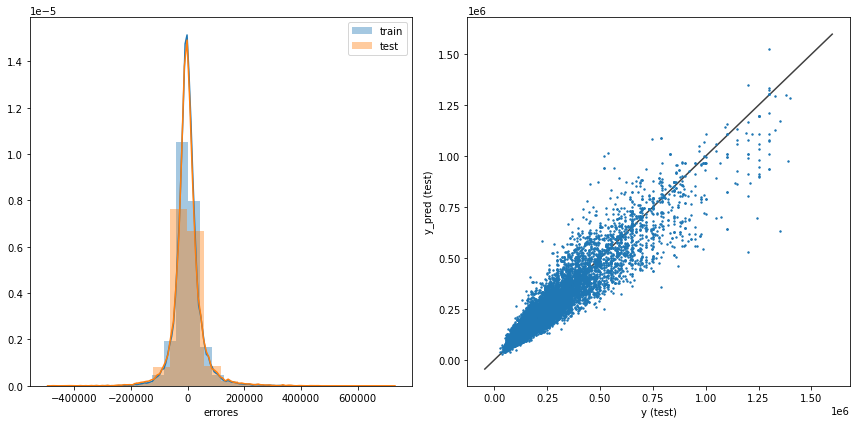

In [56]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
              colsample_bytree=0.77777777,gamma=500, learning_rate=0.5,
             n_estimators=100,max_depth=4)

    
xg_reg.fit(X_train,y_train)
preds_test = xg_reg.predict(X_test)
preds_train=xg_reg.predict(X_train)


modelos = ['xgb']

for i, model in enumerate([xg_reg]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
   # print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
   # print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (12,6))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

**PARTE C (bis) - Interpretación de modelos : XGBoost**

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

In [57]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

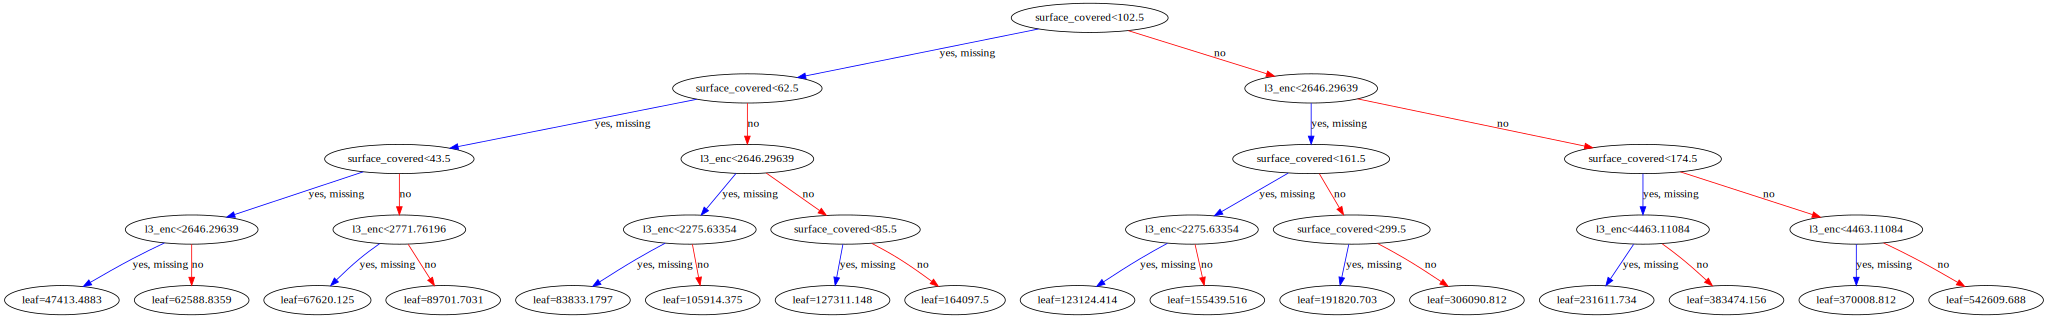

In [58]:
xgb.to_graphviz(xg_reg,num_trees=0)

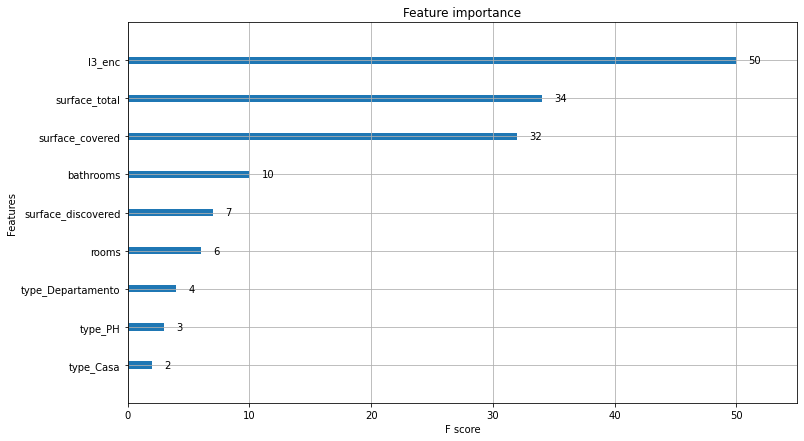

In [59]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

La variables más importantes fuerOn superficie total, superficie descubierta y rooms. No coincidia con lo que esperaba de antemano, porque creí que las variables más relevantes serían las mismas que el random forest (de acuerdo a lo investigado, en general es más útil analizar la importancia de features a través de RF)

En cuanto a la distribución de errores: la interpretación análoga a la de random forest: Los errores se distribuyen de una manera aproximadamente normal, sin embargo se observa un pequeño sesgo hacia la derecha, lo que indica que, en el caso de que el precio sea demasiado alto, el modelo tiende a indicar un precio menor. Esto se puede deber a que para las propiedades más caras existen factores que exceden al modelo como pueden ser la presencia de garage, pileta, etc.

# Conclusión Final:

Después de realizar las transformaciones en el dataset se obtuvo una mejora considerable en las predicciones utilizando el árbol de decisión simple (modelo de la primera entrega).
A su vez, al incorporar ensambles se logró obtener mayores reducciones considerables en el rmse. De tener que elegir un modelo, probablemente el más adecuado sea el Random Forest por tres razones fundamentales:
- escalibilidad: se puede entrenar un árbol simple para tener una noción general del funcionamiento del modelo y luego se pueden reducir el error de test y el overfitting al utilizar más estimadores.
- sencillez: a pesar de que se entrenó con todos los features el XGBoost no logró mejorar demasiado las predicciones, siendo un modelo bastante más complejo.
- interpretabilidad: la interpretación de un árbol único es simple, siguiendo esta lógica, la conclusión es análoga en el caso del random forest (funciona de la misma manera). Esto se ve reflejado sobre todo al realizar el análisis de la importancia de los features. 
Probablemente se pueda seguir trabajando en el procesamiento de los features más importantes o enriquecer el dataset y lograr así obtener mejores predicciones (esto lo sabemos gracias a la importancia de features del rf).
Sin embargo, debe tenerse en cuenta que es probable que para realizar una predicción del precio de viviendas más avanzada se quiera incorporar mayor cantidad de características (sobre todo para predecir los precios más altos, que es donde se verificaron mayores errores), por lo que posiblemente se puedan lograr mejores predicciones con el XGBoost por permitir regularización.
En cuanto a las mejoras, probablemente hubiese sido mejor limitar aun más los precios máximos dado que al querer incorporar casas (se tuvo que extender la superficie) y barrios caros (hay un gran salto en Puerto Madero con respecto al resto) se realizó un preprocesamiento que trató de contemplar las propiedades con precios más elevados, sin lograr los mismos resultados que para los valores medios y bajos.